# INF200 Lecture No J03
### Hans Ekkehard Plesser / NMBU
### 8 January 2018

## Today's topics

- More on testing
    - unit/integration/acceptance/regression testing
    - file layout
    - approximate comparisons
    - mocking
    - fixtures
- Statistical tests and random selection

# NOTE: THE EXAMPLE PROJECTS USE "WRONG" PROJECT LAYOUT.

## More on testing

### Levels of testing

- *unit tests* are tests of small parts of code
    - test individual methods
- *integration tests* test that the parts of a larger project work together
    - test that class instances behave as expected
    - expect that a class, e.g., representing a landscape cell, properly manages animals
- *acceptance tests* test that the software as a whole
    - `check_sim.py`
    - `test_biosim_interface.py`
    - similar simulations, e.g., with parameter modifications
        - different islands and initial populations
        - parameter choices preventing birth, death, eating, movement, ...
- *regression tests* are added when a bug is discovered
    - the test reproduces the bug
    - when the bug is fixed, the test passes
    - we keep the test, in case we should re-introduce the bug by a later change (regress)
    
### File layout

- You should write different test modules (files) to keep everything neat and organized
- Rule of thumb: One test module for each module in your package
    - `animals.py` ---> `test_animals.py`
    - `landscape.py` ---> `test_landscape.py`
    - ...
- Each individual test function should be given a descriptive name
    - When a test fails, the first thing you read is the name
        - Should describe what was tested and failed
    - Should write a docstring to further explain the test
    
#### Placement of tests

- Two alternatives, no definite "best" solution
- See https://docs.python-guide.org/writing/structure/ for a discussion on structure
- See course repository `Project/SampleProjects`
- Both variants can be run in the same way from PyCharm by adding a py.test configuration covering the entire `chutes_project_varX` directory

##### Variant 1: tests in code directory
```
chutes_project_var1/
   src/chutes/
      __init__.py
      player.py 
      tests/
         __init__.py
         test_board.py
   examples/
   setup.py
```
- `tests` is subdirectory of `chutes` code directory
- `tests` is a package
- test files use relative imports
```
from ..board import Board
```
- `setup.py` specificies `tests` as installable package (details later)
```
      packages=['chutes', 'chutes.tests'],
```

##### Variant 2: tests parallel to code directory
```
chutes_project_var2/
   chutes/
      __init__.py
      player.py 
   examples/
   tests/
      test_board.py
   setup.py
```
- `tests` is a directory "parallel" to `chutes` code directory
- `tests` is *not* a package
- test files use absolute imports
```
from chutes.board import Board
```
- `setup.py` specificies only `chutes` as installable package (details later)
```
      packages=['chutes'],
```

**We will use Variant 2.**

### Approximate comparisons


In [1]:
import numpy as np

In [2]:
from pytest import approx

Check if two numbers are equal to within a relative error of $10^{-6}$

In [3]:
3.001 == approx(3)

False

In [4]:
3.0000001 == approx(3)

True

Comparing to zero uses absolute error of $10^{-12}$

In [5]:
0.0001 == approx(0)

False

In [6]:
0.0000000000001 == approx(0)

True

Approximate comparisons also work for composite data types:

In [7]:
[1.000001, 3] == approx([1.000001, 3]) 

True

In [8]:
{'a': 1.000001, 'b': 3} == approx({'a': 1.000001, 'b': 3}) 

True

In [9]:
np.array([1.000001, 3]) == approx(np.array([1.000001, 3]))

True

See https://docs.pytest.org/en/latest/reference.html#pytest-approx for details.

### Mocking

- Temporarily replace a Python object with a different one, typically replacing a class or method
- Supported by Python `unittest.mock`
    - Relatively complex
    - We will not use it directly
    - For documentation, see
        - https://docs.python.org/3/library/unittest.mock-examples.html
        - https://docs.python.org/3/library/unittest.mock.html#the-mock-class
- For convenient mocking with py.test, we need a py.test extension `pytest-mock`
    - If you use Anaconda Python, install with `conda install pytest-mock` or via the Conda package manager
    - Otherwise install with `pip install pytest-mock`
    - For documentation, see https://github.com/pytest-dev/pytest-mock/

#### Example: Replacing random number generator with fixed value

- See also `Project/SampleProjects/chutes_project_var2`
- In the test below, `random.randint` is replaced by a function that always returns `1`. The modification is in force only in that test.

```python
def test_single_step_one(mocker):
    mocker.patch('random.randint', return_value=1)
    b = Board(chutes=[], ladders=[])
    pl = Player(b)
    pl.move()
    assert pl.position == 1
```

- `mocker` is automatically provided by py.test if the `pytest-mock` extension is installed, no imports required

#### Example: Counting the number of calls to a method

- See `Project/SampleProjecs/biolab_project/biolab/tests/test_dish.py`

```python
class TestAgingCalls:
    def test_dish_ages(self, mocker):
        mocker.spy(Bacteria, 'ages')

        n_a, n_b = 10, 20
        d = Dish(n_a, n_b)
        d.aging()

        assert Bacteria.ages.call_count == n_a + n_b
```

- `mocker.spy()` wraps `Bacteria.ages` so we can extract information later
- `Bacteria.ages.call_count` gives the number of times `Bacteria.ages` has been called
- The "spy" has an effect only inside this test

#### Example: Checking that all calls are made on different objects

- See `test_dish.py` as well
- Note that `Bacteria.ages()` is called with `self` as only argument

```python
class TestAgingCalls:
    def test_dish_ages_callers(self, mocker):
        mocker.spy(Bacteria, 'ages')

        n_a, n_b = 10, 20
        d = Dish(n_a, n_b)
        d.aging()

        args = Bacteria.ages.call_args_list
        pos_args, kwargs = zip(*args)
        assert len(set(pos_args)) == len(pos_args)
```

- `call_args_list` gives us the arguments for all calls to `ages`
- The arguments are given as tuples `(positional arguments, keyword arguments)`
- We are interested only on the positional arguments (`self`)
- We want to check if each call was made for a different object

### Fixtures

- Set up or clean up things before/after a test
- Parameterize tests: run one test several times with different values
- For more information, see
    - http://pytest.readthedocs.io/en/latest/fixture.html#fixture
    - http://pytest.readthedocs.io/en/latest/parametrize.html#parametrize
    - PyTest-related material at http://pythontesting.net/start-here/

```python
class TestDeathDivision:
    """
    Tests for death and division.

    The main point of this test class is to show the use of a fixture
    to create an initial population before each test.
    """

    @pytest.fixture(autouse=True)
    def create_dish(self):
        self.n_a = 10
        self.n_b = 20
        self.dish = Dish(self.n_a, self.n_b)

    @pytest.fixture
    def p_death_one(self):
        # set death probability to 1 before test (setup)
        Bacteria.set_params({'p_death': 1})
        yield
        # code after yield executed after test (teardown)
        Bacteria.set_params(Bacteria.default_params)

    def test_death(self):
        # test of fixture: do we have a "fresh" dish?
        n_a_old = self.dish.get_num_a()
        n_b_old = self.dish.get_num_b()
        assert n_a_old == self.n_a
        assert n_b_old == self.n_b

        for _ in range(10):
            self.dish.death()
            n_a = self.dish.get_num_a()
            n_b = self.dish.get_num_b()
            assert n_a <= n_a_old
            assert n_b <= n_b_old
            n_a_old, n_b_old = n_a, n_b

        # after 10 rounds of death probability of no change is minimal
        assert self.dish.get_num_a() < self.n_a
        assert self.dish.get_num_b() < self.n_b


    def test_division(self):
        # test of fixture: do we have a "fresh" dish?
        n_a_old = self.dish.get_num_a()
        n_b_old = self.dish.get_num_b()
        assert n_a_old == self.n_a
        assert n_b_old == self.n_b

        for _ in range(10):
            self.dish.division()
            n_a = self.dish.get_num_a()
            n_b = self.dish.get_num_b()
            assert n_a >= n_a_old
            assert n_b >= n_b_old
            n_a_old, n_b_old = n_a, n_b

        # after 10 rounds of death probability of no change is minimal
        assert self.dish.get_num_a() > self.n_a
        assert self.dish.get_num_b() > self.n_b

    def test_all_die(self, p_death_one):
        self.dish.death()
        assert self.dish.get_num_a() == 0
        assert self.dish.get_num_b() == 0

    def test_zz_p_death_fine(self):
        """
        Test to check that p_death modified only in test_all_die.
        """
        assert Bacteria.p_death == Bacteria.default_params['p_death']


@pytest.mark.parametrize("n_a, n_b, p_death",
                         [[100, 200, 0.1],
                          [100, 200, 0.9],
                          [10, 20, 0.5]])
def test_death(n_a, n_b, p_death):
    Bacteria.set_params({'p_death': p_death})
    dish = Dish(n_a, n_b)
    dish.death()
    Bacteria.set_params(Bacteria.default_params)

    died_a = n_a - dish.get_num_a()
    died_b = n_b - dish.get_num_b()
    assert binom_test(died_a, n_a, p_death) > ALPHA
    assert binom_test(died_b, n_b, p_death) > ALPHA    
```

## Statistical tests and random selection

- Test methods that depend on random numbers
- Exact results will depend on precise sequence of random numbers generated, i.e., on the random generator used and the random seed

### Basic approaches

#### Fixed seed
By seeding the random number generator with a fixed value, we can ensure that we always get the same sequence of random numbers; particularly important while debugging.

- Requires that we know which random number generator is used by methods tested
- Adding more tests or changing tests or code can change the way in which random numbers are consumed

#### Mocking
Mock the random number function to return a fixed value.

- Allows us to check that the code using the random numbers works as expected
- Does not test whether the result has the expected distribution

#### Statistical tests

- The principal approach is based on statistical testing of hypothesis
    - Formulate a hypothesis (expectation), e.g., "value $x$ is a sample of random variable $X$ which has a normal (Gaussian) distribution of given mean $\mu$ and variance $\sigma$"
    - Find the $p$-value of $x$, i.e., the probability to observe a value at least as far from the mean as $x$ if $x$ indeed follows the assumed distribution
    - Compare the $p$-value to a predefined acceptance limit $\alpha$: if $p>\alpha$ the test is passed
- Interpretation: Let, e.g., $\alpha=0.01=1\%$. If we observe a value $x$ with a $p$-value less than $\alpha=1\%$, this means that the value $x$ belongs to the outer tail of the assumed distribution, among those values that make up the 1% least likely values in the distribution. We thus assume that $x$ did not come from the expected distribution and declare the test failed.
- Note: By construction, this test will fail in 1% of all cases even if $x$ follows the assumed distribution. Thus, failures need to be inspected carefully.
- See, e.g., Knuth, The Art of Computer Programming, vol 2.

#### Types of statistical tests

- [$Z$-test](https://en.wikipedia.org/wiki/Z-test)
    - Strictly speaking, tests whether the mean of $n$ random values drawn independently from the same distribution is from a Gaussian distribution of given mean and variance 
    - Due to the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem), it can also be applied in many other cases as an approximation provided we are considering averages of many trials
    - If the variance of the Gaussian distribution is not know a priori, one should use [Student's $t$-test](https://en.wikipedia.org/wiki/Student%27s_t-test) instead

- [Binomial test](https://en.wikipedia.org/wiki/Binomial_test)
    - An explicit test for binomially distributed quantities, e.g., the number of successes in $n$ Bernoulli experiments (coin flips)
    - See also [GraphPad](http://www.graphpad.com/guides/prism/6/statistics/index.htm?stat_binomial.htm) for an explanation of the test. The [binomial test in SciPy](http://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.binom.html) uses the same approach as GraphPad

- `scipy.stats` provides [a number of statistical test functions](http://docs.scipy.org/doc/scipy-0.16.1/reference/stats.html)



## Choosing between alternatives

- Literature: Knuth, The Art of Computer Programming, vol 2, ch 3.3-3.4 
- In a simluation, we want to choose between four alternatives with probabilities $p_0, p_1, p_2, p_3$
- Note $\sum_{n=0}^3 p_n = 1$ by definition
- Cumulative probabilities $P_n = \sum_{k=0}^n p_k$ divide unit interval in sections corresponding to events 0, 1, 2, 3
- Specifically, we choose a random number $r$ and select 

\begin{equation}
\begin{cases}
\text{event}\: 0 \quad\text{if}\; r < P_0 \\
\text{event}\: n \quad\text{if}\; P_{n-1} \leq r < P_{n}\;\; \text{for}\; n>0
\end{cases}
\end{equation}

- The following code shall select events (this method is called the *linear search* method)

In [10]:
import numpy as np
from scipy.stats import chisquare, kstest, probplot
import matplotlib.pyplot as plt

%matplotlib inline

In [11]:
plt.rcParams['figure.figsize'] = (15, 5)

In [12]:
np.random.seed(1234567)

In [13]:
p = np.array([1./8, 1./4, 1./2, 1./8])
P = np.cumsum(p)
print('p: ', p)
print('P: ', P)

n_trials = 1000
num_expected = n_trials * p
num_observed = np.zeros_like(p)

for _ in range(n_trials):
    n = 0
    while np.random.random() >= P[n]:
        n += 1
    num_observed[n] +=1
    
for n, (e, o) in enumerate(zip(num_expected, num_observed)):
    print(n, e, o)

p:  [0.125 0.25  0.5   0.125]
P:  [0.125 0.375 0.875 1.   ]
0 125.0 114.0
1 250.0 339.0
2 500.0 488.0
3 125.0 59.0


- Are these results probable if our code were correct?
- We can check with the [$\chi^2$-test](https://en.wikipedia.org/wiki/Chi-squared_test)

In [14]:
chi2, p_value = chisquare(num_observed, num_expected)
chi2, p_value

(67.788, 1.2700179646806135e-14)

- The $p$-value of $\sim 10^{-14}$ strongly suggest to reject the null-hypothesis that our code generated results distributed according to the prescribed distribution.
- **What is wrong with our code?**
    - We need to choose **one** random number
    - In the code above, we draw a new random number for each possible event we test for
- The code below is corrected

In [15]:
num_observed = np.zeros_like(p)
for _ in range(n_trials):
    n = 0
    r = np.random.random()
    while r >= P[n]:
        n += 1
    num_observed[n] +=1
    
for n, (e, o) in enumerate(zip(num_expected, num_observed)):
    print(n, e, o)

0 125.0 123.0
1 250.0 237.0
2 500.0 520.0
3 125.0 120.0


- This looks better, but what does $\chi^2$ say?

In [16]:
chi2, p_value = chisquare(num_observed, num_expected)
chi2, p_value

(1.708, 0.6351566795609129)

- $p=0.64$ gives no reason to reject the null hypothesis that our code generated numbers according to the prescribed distribution

### Refactoring the code

- We divide our code into functions, so it becomes easier to run some more experiments
- In the code above, we compute and store the cumulative probability $P$ explicitly. We can avoid this by successively subtracting from the random number $r$ the probabilities $p_n$ we have checked

In [17]:
def random_select(p):
    r = np.random.random()
    n = 0
    while r >= p[n]:
        r -= p[n]
        n += 1
    return n

def event_frequencies(p, num_events):
    event_count = np.zeros_like(p)
    for _ in range(num_events):
        event = random_select(p)
        event_count[event] += 1
    return event_count

def chi2_pval_random_select(p, num_events):
    num_expected = num_events * p
    num_observed = event_frequencies(p, num_events)
    _, p_value = chisquare(num_observed, num_expected)
    return p_value

In [18]:
chi2_pval_random_select(p, 1000)

0.4456927785538277

- The $p$-value from a single test looks fine

### Repeated tests

- To become even more certain that our random selection scheme works correctly, we can repeat `test_random_select()` many times
- The resulting $p$-values should then be uniformely distributed on $[0, 1]$
- We can test for this using the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test)

In [19]:
p_values = [chi2_pval_random_select(p, 1000) for _ in range(500)]

/Users/plesser/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


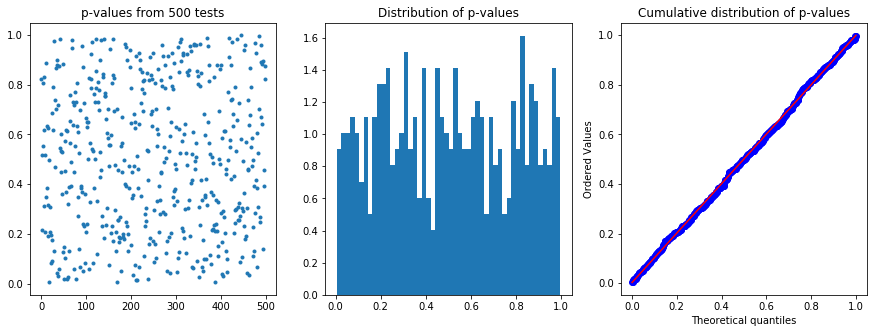

In [20]:
plt.subplot(1, 3, 1)
plt.plot(p_values, '.')
plt.title('p-values from 500 tests')

plt.subplot(1, 3, 2)
plt.hist(p_values, bins=50, histtype='stepfilled', align='mid', normed=True)
plt.title('Distribution of p-values')

plt.subplot(1, 3, 3)
probplot(p_values, dist='uniform', plot=plt)
plt.title('Cumulative distribution of p-values');

In [21]:
_, pval_ks = kstest(p_values, cdf='uniform')
pval_ks

0.9388368666525109

- This p-value is rather large, but at the $\alpha=5\%$ level does not give reason to reject the null-hypothesis that the p-values from the $\chi^2$-tests are uniformly distributed on $[0, 1]$
- We thus trust our code